In [715]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import math
from sklearn.ensemble import AdaBoostRegressor as adaboost
import sklearn.preprocessing as preprocess
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from scipy.special import boxcox, inv_boxcox
import joblib
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, SGDRegressor, LinearRegression, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor as nn

# %matplotlib notebook
#補缺失值=>onehotencoding=>normalize=>observation(remove outlier)

In [716]:
X = joblib.load('data/X_train.pkl')
y = joblib.load('data/y_train.pkl')

X_test = joblib.load('data/X_test.pkl')
# y_test = joblib.load('data/y_test.pkl')
# feat_select1_1 = joblib.load(f'saved_model_CIEX/feat_columns__stacking1.pkl')

X.drop(3231, inplace = True)
X.reset_index(drop=True, inplace = True)
y.drop(3231, inplace = True)
y.reset_index(drop=True, inplace = True)

In [717]:
y

,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,3.138889,2.161998,0.00310,0.00310
1,3.139217,2.162539,0.00355,0.00250
2,3.139260,2.161272,0.00660,0.00460
3,3.133462,2.159586,0.00445,0.00220
4,3.134885,2.160474,0.00475,0.00220
...,...,...,...,...
4957,0.733000,4.750889,0.00320,0.00265
4958,0.732655,4.751256,0.00270,0.00275
4959,0.732672,4.751435,0.00285,0.00265
4960,0.732709,4.751304,0.00295,0.00255


In [718]:
def find_cc_feat(X, y, num):
    cont_type = X.columns
    coef_dict = {}
    select_feat = []
    for i in cont_type:

        X_data = X[i].to_numpy()
        y_data = y.iloc[:, [0]].to_numpy().reshape(-1,)
        coef, pvalue = stats.spearmanr(X_data, y_data)

        bad = ~np.logical_or(np.isnan(coef), np.isnan(pvalue))

    #     print(bad)
        if bad == False:
            X.drop(columns=i, inplace=False)
    #Note that if you get a weird pvalue, 
    # https://www.zhihu.com/question/22114982
    #i dont use sperman(? cause i am lazy, so the pvalue is only as reference
        elif bad == True and pvalue <= 0.05:
            coef_dict[i] = np.abs(coef)
#             print(f'column:{i:10s}, correlation coefficient:{coef:7.4f}, test correlation pvalue output:{pvalue:2.4f}' )
        elif bad == True and pvalue >= 0.05:
            pass
        
    L = None
    L = sorted(coef_dict.items(), key=lambda item:item[1], reverse=True)
    select_feat = []
    L = L[:num]#取出前幾個相關係數最大的
    for ind in range(0, len(L)):
        select_feat.append(L[ind][0])
#     print(select_feat)
#     X_train_new = X_train[select_feat]
    joblib.dump(select_feat, f'try2/feat_columns_stacking1.pkl')

find_cc_feat(X, y, num=85)


/Users/pao/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [719]:
select_feat = joblib.load(f'try2/feat_columns_stacking1.pkl')

In [720]:
X = X[select_feat]
X_test = X_test[select_feat]

In [721]:
X_test

,TYPE_TYPE6,TYPE_TYPE1,5-3_M_M30,5-3_M_M8,5-1_M_M22,5-2_M_M22,5-1_value,5-3_value,5-2_value,4-1_M_M7,...,5-1_M_M9,5-2_M_M9,TYPE_TYPE3,1-2_value,3-1_M_M15,5-3_M_M27,3-3_cell,6-1_M_M23,6-1_M_M9,2-3_value
0,1,0,0,1,0,0,-0.599650,-0.593506,-0.884550,0,...,0,0,0,-0.299932,0,0,-0.733466,0,1,-0.206358
1,1,0,0,1,0,0,-0.610767,-0.595598,-0.884550,0,...,0,0,0,-0.618820,0,0,-0.733466,0,1,-0.080025
2,1,0,0,1,0,0,-0.506264,-0.587231,-0.684281,0,...,0,0,0,-0.253233,0,0,-0.733466,0,1,-0.199665
3,1,0,0,1,0,0,-0.486253,-0.587231,-0.619134,0,...,0,0,0,-0.536096,0,0,-0.733466,0,1,-0.208032
4,1,0,0,1,0,0,-0.670800,-0.616516,-0.886962,0,...,0,0,0,-0.562781,0,0,-0.733466,0,1,-0.189625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,0,1,1,0,1,1,1.154657,0.249479,1.144673,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.132909
5719,0,1,1,0,1,1,1.070165,0.195093,0.939580,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.131236
5720,0,1,1,0,1,1,0.999015,0.193001,0.932341,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.127053
5721,0,1,1,0,1,1,0.956769,0.195093,0.932341,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.126216


In [613]:
print(max(y['CIEX']))
print(min(y['CIEX']))
print(max(y['CIEY']))
print(min(y['CIEY']))

3.575426388888889
0.5691010638297872
4.826889772727274
1.6249874999999998


## Predict CIEX

In [722]:
# X_train, X_val, y_train, y_val = train_test_split(
#      X, y, test_size = 0.1, random_state=9
#  )
X_train, X_val, y_train, y_val = train_test_split(
     X, y, test_size = 0.1, random_state=14
 )
y_train1 = y_train['CIEX']
y_val1 = y_val['CIEX']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']

In [697]:
# fig , ax = plt.subplots(figsize=(15, 20))
# fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔

# plt.subplot(1, 3, 1).set_title('before transformation')
# plt.boxplot(y_train1)

# plt.subplot(1, 3, 2).set_title('after transformation')
# y_train1_new = trans(y_train1)
# print(y_train1_new.shape)
# plt.boxplot(y_train1_new)

# plt.subplot(1, 3, 3).set_title('inv transformation')
# y_train1_try = trans_inv(y_train1_new)
# print(y_train1_try.shape)
# plt.boxplot(y_train1_try)

In [723]:
estimators1 = [
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=2)),
        ('svr',SVR(kernel='rbf', C=0.001, gamma=0.1, epsilon=.001)),
        ('rid',Ridge(alpha=0.001,
             solver = 'sparse_cg',
             max_iter = 1200,
             tol = 1e-7)),
        ('knn', KNeighborsRegressor(n_neighbors=7, 
                                    algorithm='auto', 
                                    leaf_size=100, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('NBG', BayesianRidge(n_iter=500, 
                              tol=0.00001, 
                              alpha_1=1e-06, 
                              alpha_2=1e-06, 
                              lambda_1=1e-06, 
                              lambda_2=1e-06, 
                              compute_score=False,)),
        ('PAR',PassiveAggressiveRegressor(C=170, 
                                      max_iter=1000, 
                                      tol=0.000001, 
                                      early_stopping=True,  
                                      shuffle=True,  
                                      loss='squared_epsilon_insensitive', 
                                      epsilon=0.0001, 
                                      random_state=None)),
#         ('knn2', KNeighborsRegressor(n_neighbors=5, 
#                                     algorithm='auto', 
#                                     leaf_size=50, 
#                                     p=1,  
#                                     n_jobs=-1, )),
#         ('knn3', KNeighborsRegressor(n_neighbors=10, 
#                                     algorithm='auto', 
#                                     leaf_size=50, 
#                                     p=1,  
#                                     n_jobs=-1, )),
#           ('nn', nn(hidden_layer_sizes=(120, ), 
#                      activation='logistic',
#                      solver='adam', 
#                      alpha=0.0001, 
#                      learning_rate_init=0.01, 
#                      power_t=0.5, 
#                      max_iter=200, 
#                      shuffle=True, 
#                      random_state=None, 
#                      tol=0.000001, 
#                      early_stopping=True, 
#                      validation_fraction=0.1, 
#                      epsilon=1e-08, )),
    
    
        ]

pred1 = np.zeros([4962, 1])
for i in range(1):
    model1 = StackingRegressor(
     estimators=estimators1,
            final_estimator=RandomForestRegressor(n_estimators=500, max_depth=7, min_samples_split=2))

    model1.fit(X_train, y_train1)
#     model1.fit(X, y['CIEX'])

    pr_tr = model1.predict(X).reshape(-1,1)
    pr_tr_1 = model1.predict(X_test).reshape(-1,1)
#     pr_va = model1.predict(X_val)

#     print(sum(np.abs(pr_tr - y_train1))/pr_tr.shape[0])
#     l1 = sum(np.abs(pr_va - y_val1))/pr_va.shape[0]
#     print(l1)
    pred1 += pr_tr
pred1 /= 1

# joblib.dump(model1, f'try2/CIEX.pkl')

In [658]:
# print(sum(np.abs(pred1.reshape(-1) - y['CIEX']))/pred1.shape[0])

0.0012285279459003098


In [409]:
# joblib.dump(model1, f'try2/CIEX.pkl')

['try2/CIEX.pkl']

In [699]:
pred1

array([[3.13885893],
       [3.1388572 ],
       [3.13648877],
       ...,
       [0.7320302 ],
       [0.7320282 ],
       [0.73202469]])

## Predict CIEY

In [617]:
y

,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,3.138889,2.161998,0.00310,0.00310
1,3.139217,2.162539,0.00355,0.00250
2,3.139260,2.161272,0.00660,0.00460
3,3.133462,2.159586,0.00445,0.00220
4,3.134885,2.160474,0.00475,0.00220
...,...,...,...,...
4957,0.733000,4.750889,0.00320,0.00265
4958,0.732655,4.751256,0.00270,0.00275
4959,0.732672,4.751435,0.00285,0.00265
4960,0.732709,4.751304,0.00295,0.00255


In [900]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, test_size = 0.1, random_state=12
 )
# y_train1 = y_train['CIEX']
# y_val1 = y_val['CIEX']

y_train2 = y_train['CIEY']
y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']



In [902]:
estimators2 = [
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=2)),
        ('svr',SVR(kernel='rbf', C=0.01, gamma=0.1, epsilon=.001)),
        ('rid',Ridge(alpha=0.001,
             solver = 'sparse_cg',
             max_iter = 1200,
             tol = 1e-7)),
        ('knn', KNeighborsRegressor(n_neighbors=7, 
                                    algorithm='auto', 
                                    leaf_size=100, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('NBG', BayesianRidge(n_iter=500, 
                              tol=0.00001, 
                              alpha_1=1e-06, 
                              alpha_2=1e-06, 
                              lambda_1=1e-06, 
                              lambda_2=1e-06, 
                              compute_score=False,)),
#     ('PAR',PassiveAggressiveRegressor(C=10, 
#                                       max_iter=1000, 
#                                       tol=0.000001, 
#                                       early_stopping=True,  
#                                       shuffle=True,  
#                                       loss='squared_epsilon_insensitive', 
#                                       epsilon=0.001, 
#                                       random_state=None)),
    
        ]

pred2 = np.zeros([4962, 1])
for i in range(1):
    model2 = StackingRegressor(
     estimators=estimators2,
            final_estimator=RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=2))

    model2.fit(X_train, y_train2)
#     model2.fit(X, y['CIEY'])

    pr_tr = model2.predict(X).reshape(-1, 1)
    pr_tr_2 = model2.predict(X_test).reshape(-1,1)
#     pr_va = model2.predict(X_val)

#     print(sum(np.abs(pr_tr - y_train2))/pr_tr.shape[0])
#     l2 = sum(np.abs(pr_va - y_val2))/pr_va.shape[0]
#     print(l2)

#     print(pr_tr[0, 0])
    pred2 = pred2 + pr_tr
    
pred2 /= 1 

In [ ]:
pred2[0, 0]

In [475]:
# joblib.dump(model2, f'try2/CIEY.pkl')

['try2/CIEY.pkl']

## Predict CIEX_DIFF

In [844]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, test_size = 0.1, random_state=12
    #9
 )
y_train3 = y_train['CIEX_DIFF']
y_val3 = y_val['CIEX_DIFF']

y_train3_new = trans(y_train3)
y_val3_new = trans(y_val3)


In [842]:

def trans(y_):
    
    y = (y_ + 4.01)/4
    y = boxcox(y, -1000)
    return y

def trans_inv(y):
    y_ = inv_boxcox(y, -1000)
    y_ = y_ * 4 - 4.01 
    return y_

# def trans(y_):
#     y = y_ + 1
#     y = np.log(y)
#     return y

# def trans_inv(y):
#     y_ = np.exp(y)
#     y_ = y_ - 1 
#     return y_



In [728]:

    
# fig , ax = plt.subplots(figsize=(15, 20))
# fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔

# plt.subplot(1, 3, 1).set_title('before transformation')
# plt.boxplot(y_train3)

# plt.subplot(1, 3, 2).set_title('after transformation')
# y_train3_new = trans(y_train3)
# print(y_train3_new.shape)
# plt.boxplot(y_train3_new)

# plt.subplot(1, 3, 3).set_title('inv transformation')
# y_train3_try = trans_inv(y_train3_new)
# print(y_train3_try.shape)
# plt.boxplot(y_train3_try)


In [846]:
# y_train3 = np.log(y_train3)


estimators3 = [
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_split=2)),
        ('lib',LinearRegression()),
#         ('svr',SVR(kernel='rbf', C=0.001, gamma=0.1, epsilon=.001)),
        ('rid',Ridge(alpha=0.001,
             solver = 'sparse_cg',
             max_iter = 1200,
             tol = 1e-7),),
        ('knn1', KNeighborsRegressor(n_neighbors=7, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('NBG', BayesianRidge(n_iter=500, 
                              tol=0.00001, 
                              alpha_1=1e-06, 
                              alpha_2=1e-06, 
                              lambda_1=1e-06, 
                              lambda_2=1e-06, 
                              compute_score=False,)),
        ('knn2', KNeighborsRegressor(n_neighbors=5, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('knn3', KNeighborsRegressor(n_neighbors=10, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('PAR',PassiveAggressiveRegressor(C=100, 
                                      max_iter=1200, 
                                      tol=0.000001, 
                                      early_stopping=True,  
                                      shuffle=True,  
                                      loss='squared_epsilon_insensitive', 
                                      epsilon=0.0001, 
                                      random_state=None)),
        ]

pred3 = np.zeros([4962, 1])
for i in range(1):
    model3 = StackingRegressor(
                         estimators=estimators3,
                                final_estimator=RandomForestRegressor(n_estimators=500, max_depth=8, min_samples_split=2))

    # model3.fit(X_train, y_train3)
    model3.fit(X_train, y_train3_new)
#     model3.fit(X, trans(y['CIEX_DIFF']))

    pr_tr = trans_inv(model3.predict(X)).reshape(-1,1)#還沒變回來！
    pr_tr_3 = trans_inv(model3.predict(X_test)).reshape(-1,1)
#     pr_va = model3.predict(X_val)#還沒變回來！

#     print('true predict')
#     print(sum(np.abs(trans_inv(pr_tr) - y_train3))/y_train3.shape[0])
#     l3 = sum(np.abs(trans_inv(pr_va) - y_val3))/y_val3.shape[0]
#     print(l3)

#     print()
#     print('predict after trans')
#     print(sum(np.abs(pr_tr - y_train3_new))/y_train3_new.shape[0])
#     l3 = sum(np.abs(pr_va - y_val3_new))/y_val3_new.shape[0]
#     print(l3)

# joblib.dump(model3, f'try2/CIEX_DIFF.pkl')
    pred3 += pr_tr
    
pred3 = pred3/1

# plt.figure(figsize=(10, 10))
# # plt.axis([0, 0.2, 0, 0.2])
# plt.plot(pr_tr, y_train3_new, 'b.')
# plt.show()

In [381]:
# joblib.dump(model3, f'try2/CIEX_DIFF.pkl')

['try2/CIEX_DIFF.pkl']

In [847]:
pr_tr_3

array([[0.00507616],
       [0.00505346],
       [0.00512484],
       ...,
       [0.0031411 ],
       [0.00300534],
       [0.00293169]])

## Predict CIEY_DIFF

In [706]:
y

,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,3.138889,2.161998,0.00310,0.00310
1,3.139217,2.162539,0.00355,0.00250
2,3.139260,2.161272,0.00660,0.00460
3,3.133462,2.159586,0.00445,0.00220
4,3.134885,2.160474,0.00475,0.00220
...,...,...,...,...
4957,0.733000,4.750889,0.00320,0.00265
4958,0.732655,4.751256,0.00270,0.00275
4959,0.732672,4.751435,0.00285,0.00265
4960,0.732709,4.751304,0.00295,0.00255


In [730]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, test_size = 0.1, random_state=14
 )
# y_train1 = y_train['CIEX']
# y_val1 = y_val['CIEX']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

y_train4 = y_train['CIEY_DIFF']
y_val4 = y_val['CIEY_DIFF']


{'whiskers': [<matplotlib.lines.Line2D at 0x14aa15d90>,
 'caps': [<matplotlib.lines.Line2D at 0x14aa18850>,
 'boxes': [<matplotlib.lines.Line2D at 0x14aa15850>],
 'medians': [<matplotlib.lines.Line2D at 0x14afd8350>],
 'fliers': [<matplotlib.lines.Line2D at 0x14afd8890>],
 'means': []}

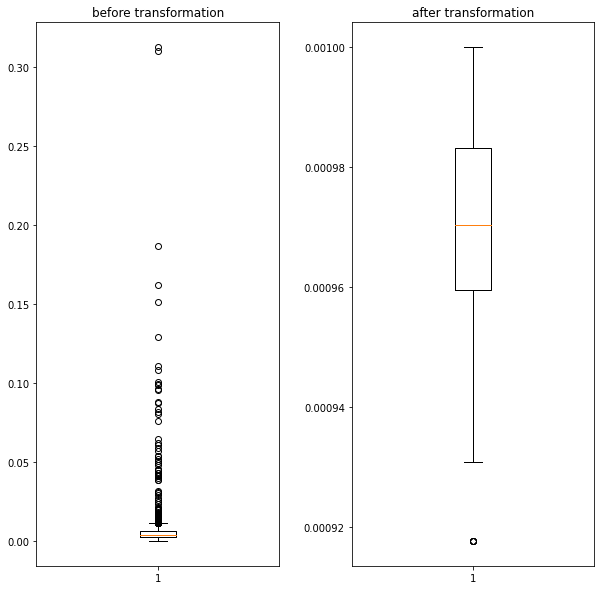

In [731]:
y_train4_new = trans(y_train4)
y_val4_new = trans(y_val4)

fig , ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #設定子圖的間隔

plt.subplot(1, 2, 1).set_title('before transformation')
plt.boxplot(y_train4)

plt.subplot(1, 2, 2).set_title('after transformation')
plt.boxplot(y_train4_new)

In [732]:
# y_train4 = np.log(y_train4)
estimators4 = [
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_split=2)),
        ('svr',SVR(kernel='rbf', C=0.01, gamma=0.1, epsilon=.001)),
        ('rid',Ridge(alpha=0.001,
             solver = 'sparse_cg',
             max_iter = 1200,
             tol = 1e-7)),
        ('knn1', KNeighborsRegressor(n_neighbors=7, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('NBG', BayesianRidge(n_iter=500, 
                              tol=0.00001, 
                              alpha_1=1e-06, 
                              alpha_2=1e-06, 
                              lambda_1=1e-06, 
                              lambda_2=1e-06, 
                              compute_score=False,)),
        ('knn2', KNeighborsRegressor(n_neighbors=5, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
        ('knn3', KNeighborsRegressor(n_neighbors=10, 
                                    algorithm='auto', 
                                    leaf_size=50, 
                                    p=1,  
                                    n_jobs=-1, )),
#         ('PAR',PassiveAggressiveRegressor(C=100, 
#                                       max_iter=1200, 
#                                       tol=0.000001, 
#                                       early_stopping=True,  
#                                       shuffle=True,  
#                                       loss='squared_epsilon_insensitive', 
#                                       epsilon=0.001, 
#                                       random_state=None)),
    
        ]
pred4 = np.zeros([4962, 1])
for i in range(1):
    model4 = StackingRegressor(
     estimators=estimators4,
        final_estimator=RandomForestRegressor(n_estimators=300, max_depth=6, min_samples_split=2))

    model4.fit(X_train, y_train4_new)
#     model4.fit(X, trans(y['CIEY_DIFF']))

    pr_tr = trans_inv(model4.predict(X)).reshape(-1, 1)#log type
    pr_tr_4 = trans_inv(model4.predict(X_test)).reshape(-1, 1)
#     pr_va = model4.predict(X_val)#log type

#     print('true predict')
#     print(sum(np.abs(trans_inv(pr_tr) - y_train4))/y_train4.shape[0])
#     l4 = sum(np.abs(trans_inv(pr_va) - y_val4))/y_val4.shape[0]
#     print(l4)

#     print()
#     print('predict after trans')
#     print(sum(np.abs(pr_tr - y_train4_new))/y_train4_new.shape[0])
#     l4 = sum(np.abs(pr_va - y_val4_new))/y_val4_new.shape[0]
#     print(l4)
    pred4 += pr_tr
pred4 /= 1

# joblib.dump(model4, f'try2/CIEY_DIFF.pkl')

In [ ]:
jjijijjjjjjjjjjjijijijijijijiji

In [827]:
X_train, X_val, y_train, y_val = train_test_split(
     pred1, y, test_size = 0.1, random_state=17
 )

y_train1 = y_train['CIEX']
y_val1 = y_val['CIEX']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']

model1 = RandomForestRegressor(n_estimators=6, max_depth=8, min_samples_split=2)

model1.fit(X_train, y_train1)

a = model1.predict(X_train)
b = model1.predict(X_val)
print(sum(np.abs(a - y_train1))/y_train1.shape[0])
print(sum(np.abs(b - y_val1))/y_val1.shape[0])

pr_tr_1_ = model1.predict(pr_tr_1).reshape(-1, 1)

0.001057131417800198
0.001096093093151119


In [903]:
X_train, X_val, y_train, y_val = train_test_split(
     pred2, y, test_size = 0.1, random_state=2
 )

y_train2 = y_train['CIEY']
y_val2 = y_val['CIEY']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']

model2 = RandomForestRegressor(n_estimators=6, max_depth=7, min_samples_split=2)

model2.fit(X_train, y_train2)

a = model2.predict(X_train)
b = model2.predict(X_val)
print(sum(np.abs(a - y_train2))/y_train2.shape[0])
print(sum(np.abs(b - y_val2))/y_val2.shape[0])

pr_tr_2_ = model2.predict(pr_tr_2).reshape(-1, 1)

0.0008417768852936154
0.0008168444175046219


In [904]:
pr_tr_2

array([[2.15991858],
       [2.15947084],
       [2.15947084],
       ...,
       [4.75137642],
       [4.75132428],
       [4.75132428]])

In [892]:
X_train, X_val, y_train, y_val = train_test_split(
     pred3, y, test_size = 0.2, random_state=6
 )

y_train3 = y_train['CIEX_DIFF']
y_val3 = y_val['CIEX_DIFF']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']

model3 = RandomForestRegressor(n_estimators=6, max_depth=6, min_samples_split=2)

model3.fit(X_train, trans(y_train3))

a = trans_inv(model3.predict(X_train))
b = trans_inv(model3.predict(X_val))
print(sum(np.abs(a - y_train3))/y_train3.shape[0])
print(sum(np.abs(b - y_val3))/y_val3.shape[0])

pr_tr_3_ = trans_inv(model3.predict(pr_tr_3)).reshape(-1, 1)

0.0019906117137149047
0.001539112893716264


In [855]:
# print(sum(np.abs(pred3.reshape(-1, 1) - y['CIEX_DIFF'].to_numpy().reshape(-1, 1)))/pred3.shape[0])

[0.00192696]


In [893]:
X_train, X_val, y_train, y_val = train_test_split(
     pred4, y, test_size = 0.2, random_state=2
 )

y_train4 = y_train['CIEY_DIFF']
y_val4 = y_val['CIEY_DIFF']

# y_train2 = y_train['CIEY']
# y_val2 = y_val['CIEY']

# y_train3 = y_train['CIEX_DIFF']
# y_val3 = y_val['CIEX_DIFF']

# y_train4 = y_train['CIEY_DIFF']
# y_val4 = y_val['CIEY_DIFF']

model4 = RandomForestRegressor(n_estimators=6, max_depth=8, min_samples_split=2)

model4.fit(X_train, trans(y_train4))

a = trans_inv(model4.predict(X_train))
b = trans_inv(model4.predict(X_val))
print(sum(np.abs(a - y_train4))/y_train4.shape[0])
print(sum(np.abs(b - y_val4))/y_val4.shape[0])

pr_tr_4_ = trans_inv(model4.predict(pr_tr_4)).reshape(-1, 1)

0.0015550221518158915
0.0011771497618804185


In [ ]:
#TEST

In [710]:
X_test

,TYPE_TYPE6,TYPE_TYPE1,5-3_M_M30,5-3_M_M8,5-1_M_M22,5-2_M_M22,5-1_value,5-3_value,5-2_value,4-1_M_M7,...,5-1_M_M9,5-2_M_M9,TYPE_TYPE3,1-2_value,3-1_M_M15,5-3_M_M27,3-3_cell,6-1_M_M23,6-1_M_M9,2-3_value
0,1,0,0,1,0,0,-0.599650,-0.593506,-0.884550,0,...,0,0,0,-0.299932,0,0,-0.733466,0,1,-0.206358
1,1,0,0,1,0,0,-0.610767,-0.595598,-0.884550,0,...,0,0,0,-0.618820,0,0,-0.733466,0,1,-0.080025
2,1,0,0,1,0,0,-0.506264,-0.587231,-0.684281,0,...,0,0,0,-0.253233,0,0,-0.733466,0,1,-0.199665
3,1,0,0,1,0,0,-0.486253,-0.587231,-0.619134,0,...,0,0,0,-0.536096,0,0,-0.733466,0,1,-0.208032
4,1,0,0,1,0,0,-0.670800,-0.616516,-0.886962,0,...,0,0,0,-0.562781,0,0,-0.733466,0,1,-0.189625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,0,1,1,0,1,1,1.154657,0.249479,1.144673,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.132909
5719,0,1,1,0,1,1,1.070165,0.195093,0.939580,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.131236
5720,0,1,1,0,1,1,0.999015,0.193001,0.932341,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.127053
5721,0,1,1,0,1,1,0.956769,0.195093,0.932341,0,...,0,0,0,-0.059098,0,0,-0.733466,0,1,2.126216


In [382]:
label_name = ['CIEX', 'CIEY', 'CIEX_DIFF', 'CIEY_DIFF']
outcome = np.empty([5723, 0])
for i in range(4):
    model = joblib.load(f'try2/{label_name[i]}.pkl')
    if i <= 1:
        pred = model.predict(X_test).reshape(-1, 1)
#         print(pred)
        outcome = np.hstack((outcome, pred))
    elif i>=2:
#         print(pred)
        pred = trans_inv(model.predict(X_test)).reshape(-1, 1)
#         print(pred)
        outcome = np.hstack((outcome, pred))
#         print(outcome)



In [628]:
outcome

array([[3.13867829e+00, 2.16024949e+00, 4.96325081e-03, 3.58025907e-03],
       [3.13713433e+00, 2.15936095e+00, 4.91641515e-03, 3.22997277e-03],
       [3.13713433e+00, 2.15943773e+00, 4.98340406e-03, 3.55521965e-03],
       ...,
       [7.31970472e-01, 4.75148139e+00, 3.14793676e-03, 2.73135896e-03],
       [7.31961963e-01, 4.75141624e+00, 3.06824336e-03, 2.75740538e-03],
       [7.31956824e-01, 4.75140523e+00, 2.96896114e-03, 2.76299824e-03]])

In [883]:
data0 = pd.read_csv("data/sub2.csv", low_memory=False)

In [683]:
# data0['CIEX'] = pred1
# data0['CIEY'] = pred2
# data0['CIEX_DIFF'] = pred3
# data0['CIEY_DIFF'] = pred4

In [905]:
data0['CIEX'] = pr_tr_1_
data0['CIEY'] = pr_tr_2_
data0['CIEX_DIFF'] = pr_tr_3_
data0['CIEY_DIFF'] = pr_tr_4_

In [899]:
data0

,id,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,2,3.138436,3.130983,0.005010,0.003371
1,4,3.137128,3.130983,0.005010,0.003048
2,5,3.137128,3.130983,0.005010,0.003389
3,7,3.138246,3.130983,0.005010,0.003972
4,10,3.138436,3.130983,0.005010,0.003706
...,...,...,...,...,...
5718,10674,0.732028,1.625235,0.003064,0.002760
5719,10675,0.732028,1.625235,0.002991,0.002812
5720,10676,0.731980,1.625235,0.002991,0.002731
5721,10680,0.731980,1.625235,0.002937,0.002760


In [896]:
data0

,id,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,2,3.138436,3.130983,0.005010,0.003371
1,4,3.137128,3.130983,0.005010,0.003048
2,5,3.137128,3.130983,0.005010,0.003389
3,7,3.138246,3.130983,0.005010,0.003972
4,10,3.138436,3.130983,0.005010,0.003706
...,...,...,...,...,...
5718,10674,0.732028,1.625235,0.003064,0.002760
5719,10675,0.732028,1.625235,0.002991,0.002812
5720,10676,0.731980,1.625235,0.002991,0.002731
5721,10680,0.731980,1.625235,0.002937,0.002760


In [906]:
data0.to_csv("data/sub2.csv", index=False)

In [881]:
data = pd.read_csv("data/submission.csv", low_memory=False)

In [882]:
data

,id,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
0,2,3.138678,2.160230,0.004966,0.003580
1,4,3.137134,2.159414,0.004961,0.003230
2,5,3.137134,2.159569,0.005001,0.003555
3,7,3.138528,2.159562,0.004896,0.004036
4,10,3.138702,2.159433,0.004991,0.003644
...,...,...,...,...,...
5718,10674,0.731971,4.751474,0.003262,0.002757
5719,10675,0.731972,4.751415,0.003188,0.002744
5720,10676,0.731970,4.751394,0.003150,0.002731
5721,10680,0.731962,4.751364,0.003025,0.002757


In [171]:
0.294*0.0012+0.330*0.001+0.172*0.0019+0.204*0.0012


0.0012543999999999997

In [389]:
# data['CIEX'] = data0['CIEX']

In [390]:
# data.to_csv("data/sub2.csv", index=False)

# 正式來囉

In [276]:
X = joblib.load('data/X_train.pkl')
y = joblib.load('data/y_train.pkl')

X_test = joblib.load('data/X_test.pkl')
# y_test = joblib.load('data/y_test.pkl')
# feat_select1_1 = joblib.load(f'saved_model_CIEX/feat_columns__stacking1.pkl')

X.drop(3231, inplace = True)
X.reset_index(drop=True, inplace = True)
y.drop(3231, inplace = True)
y.reset_index(drop=True, inplace = True)

X_train = X[select_feat].to_numpy()
X_test = X_test[select_feat].to_numpy()

y_train1 = y['CIEX'].to_numpy()
y_train2 = y['CIEY'].to_numpy()
y_train3 = y['CIEX_DIFF'].to_numpy()
y_train4 = y['CIEY_DIFF'].to_numpy()

In [277]:
y_train1

array([3.13888902, 3.13921724, 3.13925988, ..., 0.73267211, 0.7327086 ,
       0.73278424])

In [278]:
model1 = StackingRegressor(
 estimators=estimators1,
        final_estimator=RandomForestRegressor(n_estimators=250, max_depth=7, min_samples_split=2))

model1.fit(X_train, y_train1)

pr_tr = model1.predict(X_train)
print(sum(np.abs(pr_tr - y_train1))/pr_tr.shape[0])

# joblib.dump(model1, f'try2/CIEX.pkl')

0.0027015369661434305


In [394]:
0.0000156/0.294

5.306122448979592e-05